In [18]:
from matplotlib import pyplot as plt
from jupyter_plotter import plot_jupyter_figure
import pymatching # Decoding
from circuit_generators import *
from sampling_functions import *
import numpy as np
from copy import deepcopy

n_worker_nodes = 8

#Surface Code specification
d = 3
r = 2
use_rotated_z = True

# Generate random noise parameter p using a lambda function
generate_random_noise = lambda low=0.01, high=0.05: np.random.uniform(low, high)  


# Bit types
binary_t = np.int8 # Could use even less if numpy allowed
# Packed bit type
packed_t = np.int8 
if d<=8:
  pass
elif d>8 and d<=16:
  packed_t = np.int16
elif d>16 and d<=32:
  packed_t = np.int32
elif d>32 and d<=64:
  packed_t = np.int64
elif d>64 and d<=128:
  packed_t = np.int128
elif d>128 and d<=256:
  packed_t = np.int256
else:
  raise RuntimeError("d is too large.")
time_t = np.int8


In [19]:

# Measurement index type
idx_t = np.int8
#n_all_measurements determines the number of all mesurments
n_all_measurements = r*(d**2-1) + d**2

if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int16
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int32
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int64
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int128
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int256
if n_all_measurements > np.iinfo(idx_t).max:
  raise RuntimeError("idx_t is too small.")

In [20]:

n_samples = 10000000
decoders = ['pymatching']

def insert_random_noise(circuit, qubitsNum):
  """"
  Wrapper to generate a random noise model on each qubit.
  - Arguments:
    circuit: A stim.Circuit object.
    qubitsNum: Number of qubits in the circuit.
  - Return type:
    stim.Circuit
  """
  random_noise = np.random.uniform(0.01, 0.05 , size=qubitsNum)
  depolarize2_rates = np.random.uniform(0.01, 0.05, size=(qubitsNum, qubitsNum))

#Generating random noise for each qubit
  for qubit in range(qubitsNum):
    error_rate = random_noise[qubit]
    print(f"Qubit {qubit}: X_ERROR rate = {error_rate}, DEPOLARIZE1 rate = {error_rate}")
    circuit.append_operation("X_ERROR",[qubit], error_rate)
    circuit.append_operation("Depolarize1",[qubit], error_rate)

  #Generating randm noise for Depolarize2 for each pair of qubits
  for i in range(qubitsNum):
    for j in range(i + 1, qubitsNum):
            error_rate = depolarize2_rates[i, j]
            print(f"Qubit pair ({i}, {j}): DEPOLARIZE2 rate = {error_rate}")
            circuit.append_operation("DEPOLARIZE2", [i, j], error_rate)
  return circuit


In [26]:
test_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
  distance=d,
  rounds=r,
  before_round_data_depolarization = generate_random_noise(),
  after_reset_flip_probability = generate_random_noise(),
  after_clifford_depolarization = generate_random_noise(),
  before_measure_flip_probability = generate_random_noise(),
)


Average flip rate: 0.2757938
QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.0384052) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.0384052) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.013238) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.0219069) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.0219069) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.0219069) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.0219069) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.0219069) 16 8 11 3 25 17 1 9 10 18

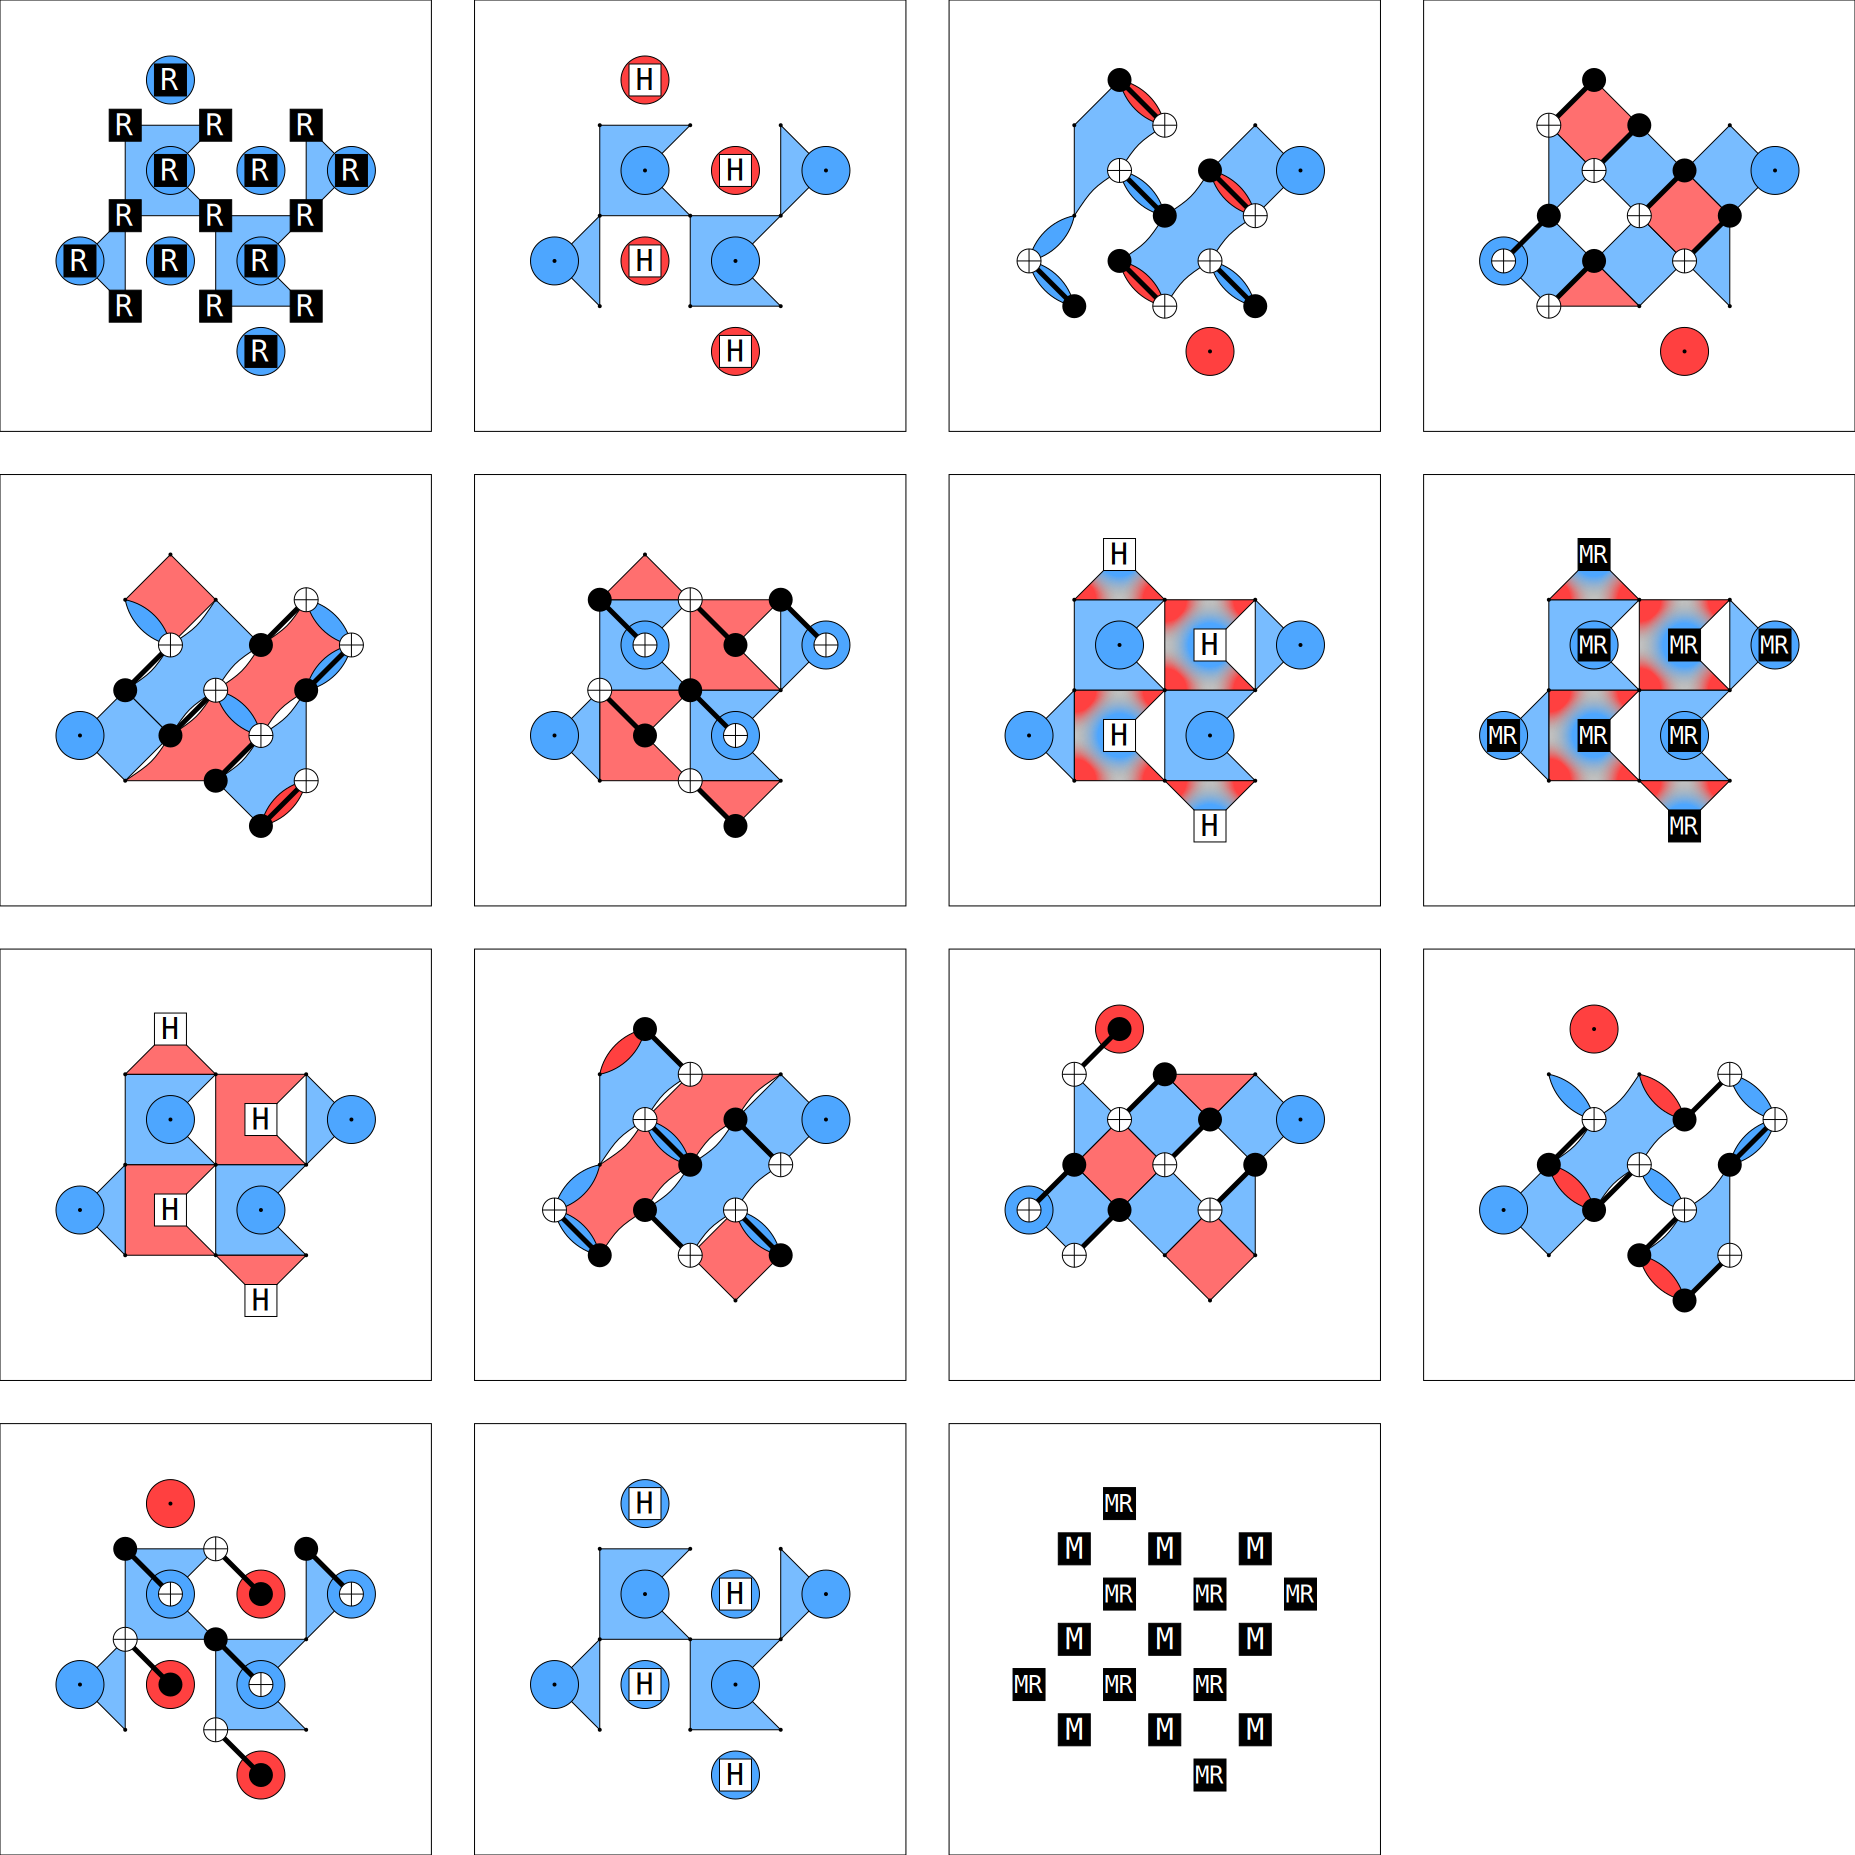

In [27]:
m_sampler = test_circuit.compile_sampler(seed=12345)
d_sampler = test_circuit.compile_detector_sampler(seed=12345)
converter = test_circuit.compile_m2d_converter()

measurements = m_sampler.sample(n_samples, bit_packed=False)
det_evts, flips = converter.convert(measurements=measurements, separate_observables=True, bit_packed=False)
measurements = measurements.astype(binary_t)
det_evts = det_evts.astype(binary_t)
flips = flips.astype(binary_t)

avg_flips = np.sum(flips.reshape(-1,), dtype=np.float32)/flips.shape[0]
print(f"Average flip rate: {avg_flips}")

print(test_circuit)
test_circuit.without_noise().diagram('detslice-with-ops-svg')


In [29]:
test_circuit = insert_random_noise(test_circuit, d**2)


Qubit 0: X_ERROR rate = 0.019389118332996853, DEPOLARIZE1 rate = 0.019389118332996853
Qubit 1: X_ERROR rate = 0.011159058413345555, DEPOLARIZE1 rate = 0.011159058413345555
Qubit 2: X_ERROR rate = 0.027597760759862887, DEPOLARIZE1 rate = 0.027597760759862887
Qubit 3: X_ERROR rate = 0.014560107213918934, DEPOLARIZE1 rate = 0.014560107213918934
Qubit 4: X_ERROR rate = 0.037217905366977604, DEPOLARIZE1 rate = 0.037217905366977604
Qubit 5: X_ERROR rate = 0.029487633957620475, DEPOLARIZE1 rate = 0.029487633957620475
Qubit 6: X_ERROR rate = 0.01641430746740173, DEPOLARIZE1 rate = 0.01641430746740173
Qubit 7: X_ERROR rate = 0.025636815396072057, DEPOLARIZE1 rate = 0.025636815396072057
Qubit 8: X_ERROR rate = 0.04698805642707303, DEPOLARIZE1 rate = 0.04698805642707303
Qubit pair (0, 1): DEPOLARIZE2 rate = 0.0322217683165361
Qubit pair (0, 2): DEPOLARIZE2 rate = 0.017504390413689914
Qubit pair (0, 3): DEPOLARIZE2 rate = 0.019072404723348514
Qubit pair (0, 4): DEPOLARIZE2 rate = 0.021895841311271